# qGAN for Randomized Data classification

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
pip install qiskit_algorithms pennylane torch qiskit qiskit-algorithms pylatexenc qiskit_machine_learning

In [29]:
import torch
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

In [30]:
with open('AI_2qubits_training_data.txt', 'r') as file:
    data = file.readlines()

type_1=data[:2000]
type_2=data[2001:4000]
type_3=data[4001:6000]
delimiter = ' '
first_column_1 = [row.split(delimiter)[0] for row in type_1]
first_column_2 = [row.split(delimiter)[0] for row in type_2]
first_column_3 = [row.split(delimiter)[0] for row in type_3]

def frequency(first_column):
    frequencies_per_row = []
    for row in first_column:
        frequency_1 = 0
        frequency_0 = 0
        for bit in row:
            if bit == '1':
                frequency_1 += 1
            elif bit == '0':
                frequency_0 += 1
        total_bits = len(row)
        distribution = {'1': frequency_1 / total_bits, '0': frequency_0 / total_bits}
        frequencies_per_row.append(distribution['1'])

    return frequencies_per_row

values_1 = frequency(first_column_1)
values_2 = frequency(first_column_2)
values_3 = frequency(first_column_3)

In [31]:
len(values_1)

2000

In [32]:
import numpy as np

count1 = np.zeros(64)
for string in type_1:
    for i, bit in enumerate(string[:-39]):
        if bit == '1':
            count1[i] += 1
count1 = (count1)/2000

count2 = np.zeros(64)
for string in type_2:
    for i, bit in enumerate(string[:-39]):
        if bit == '1':
            count2[i] += 1
count2 = (count2)/2000

count3 = np.zeros(64)
for string in type_3:
    for i, bit in enumerate(string[:-39]):
        if bit == '1':
            count3[i] += 1
count3 = (count3)/2000

In [33]:
len(count2)

64

In [34]:
import numpy as np

num_dim = 2
num_discrete_values = 64
num_qubits = num_dim * int(np.log2(num_discrete_values))

In [35]:
print(num_discrete_values, num_qubits)

64 12


In [36]:
grid_data = []
for i in range(64):
    grid_data.append([])
    for j in range(64):
        grid_data[i].append(count1[j]-count2[i])

grid_data= np.array(grid_data)-np.min(grid_data)

In [37]:
grid_data

array([[0.179 , 0.265 , 0.1735, ..., 0.266 , 0.1565, 0.2755],
       [0.078 , 0.164 , 0.0725, ..., 0.165 , 0.0555, 0.1745],
       [0.166 , 0.252 , 0.1605, ..., 0.253 , 0.1435, 0.2625],
       ...,
       [0.084 , 0.17  , 0.0785, ..., 0.171 , 0.0615, 0.1805],
       [0.172 , 0.258 , 0.1665, ..., 0.259 , 0.1495, 0.2685],
       [0.065 , 0.151 , 0.0595, ..., 0.152 , 0.0425, 0.1615]])

In [38]:
coords = np.linspace(0, 1, num_discrete_values)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])

In [39]:
grid_data.shape

(64, 64)

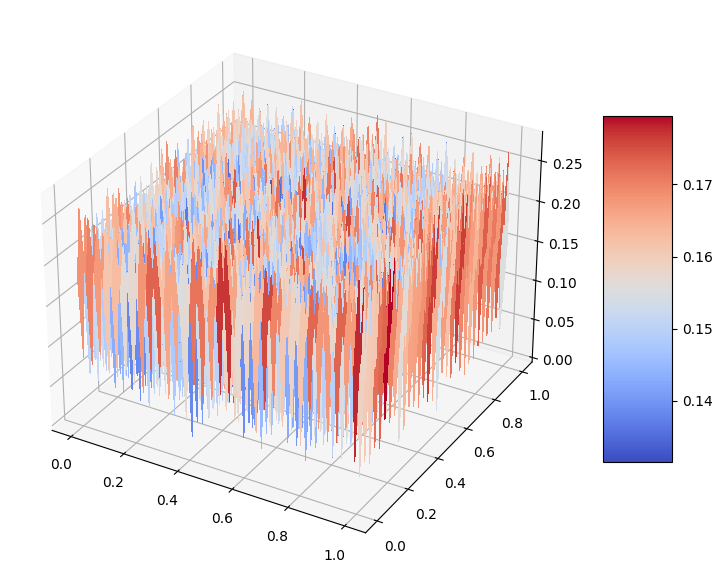

In [40]:
import matplotlib.pyplot as plt
from matplotlib import cm

coords = np.linspace(0, 1, num_discrete_values)

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(grid_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, grid_data, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [41]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=4)
qc.compose(ansatz, inplace=True)

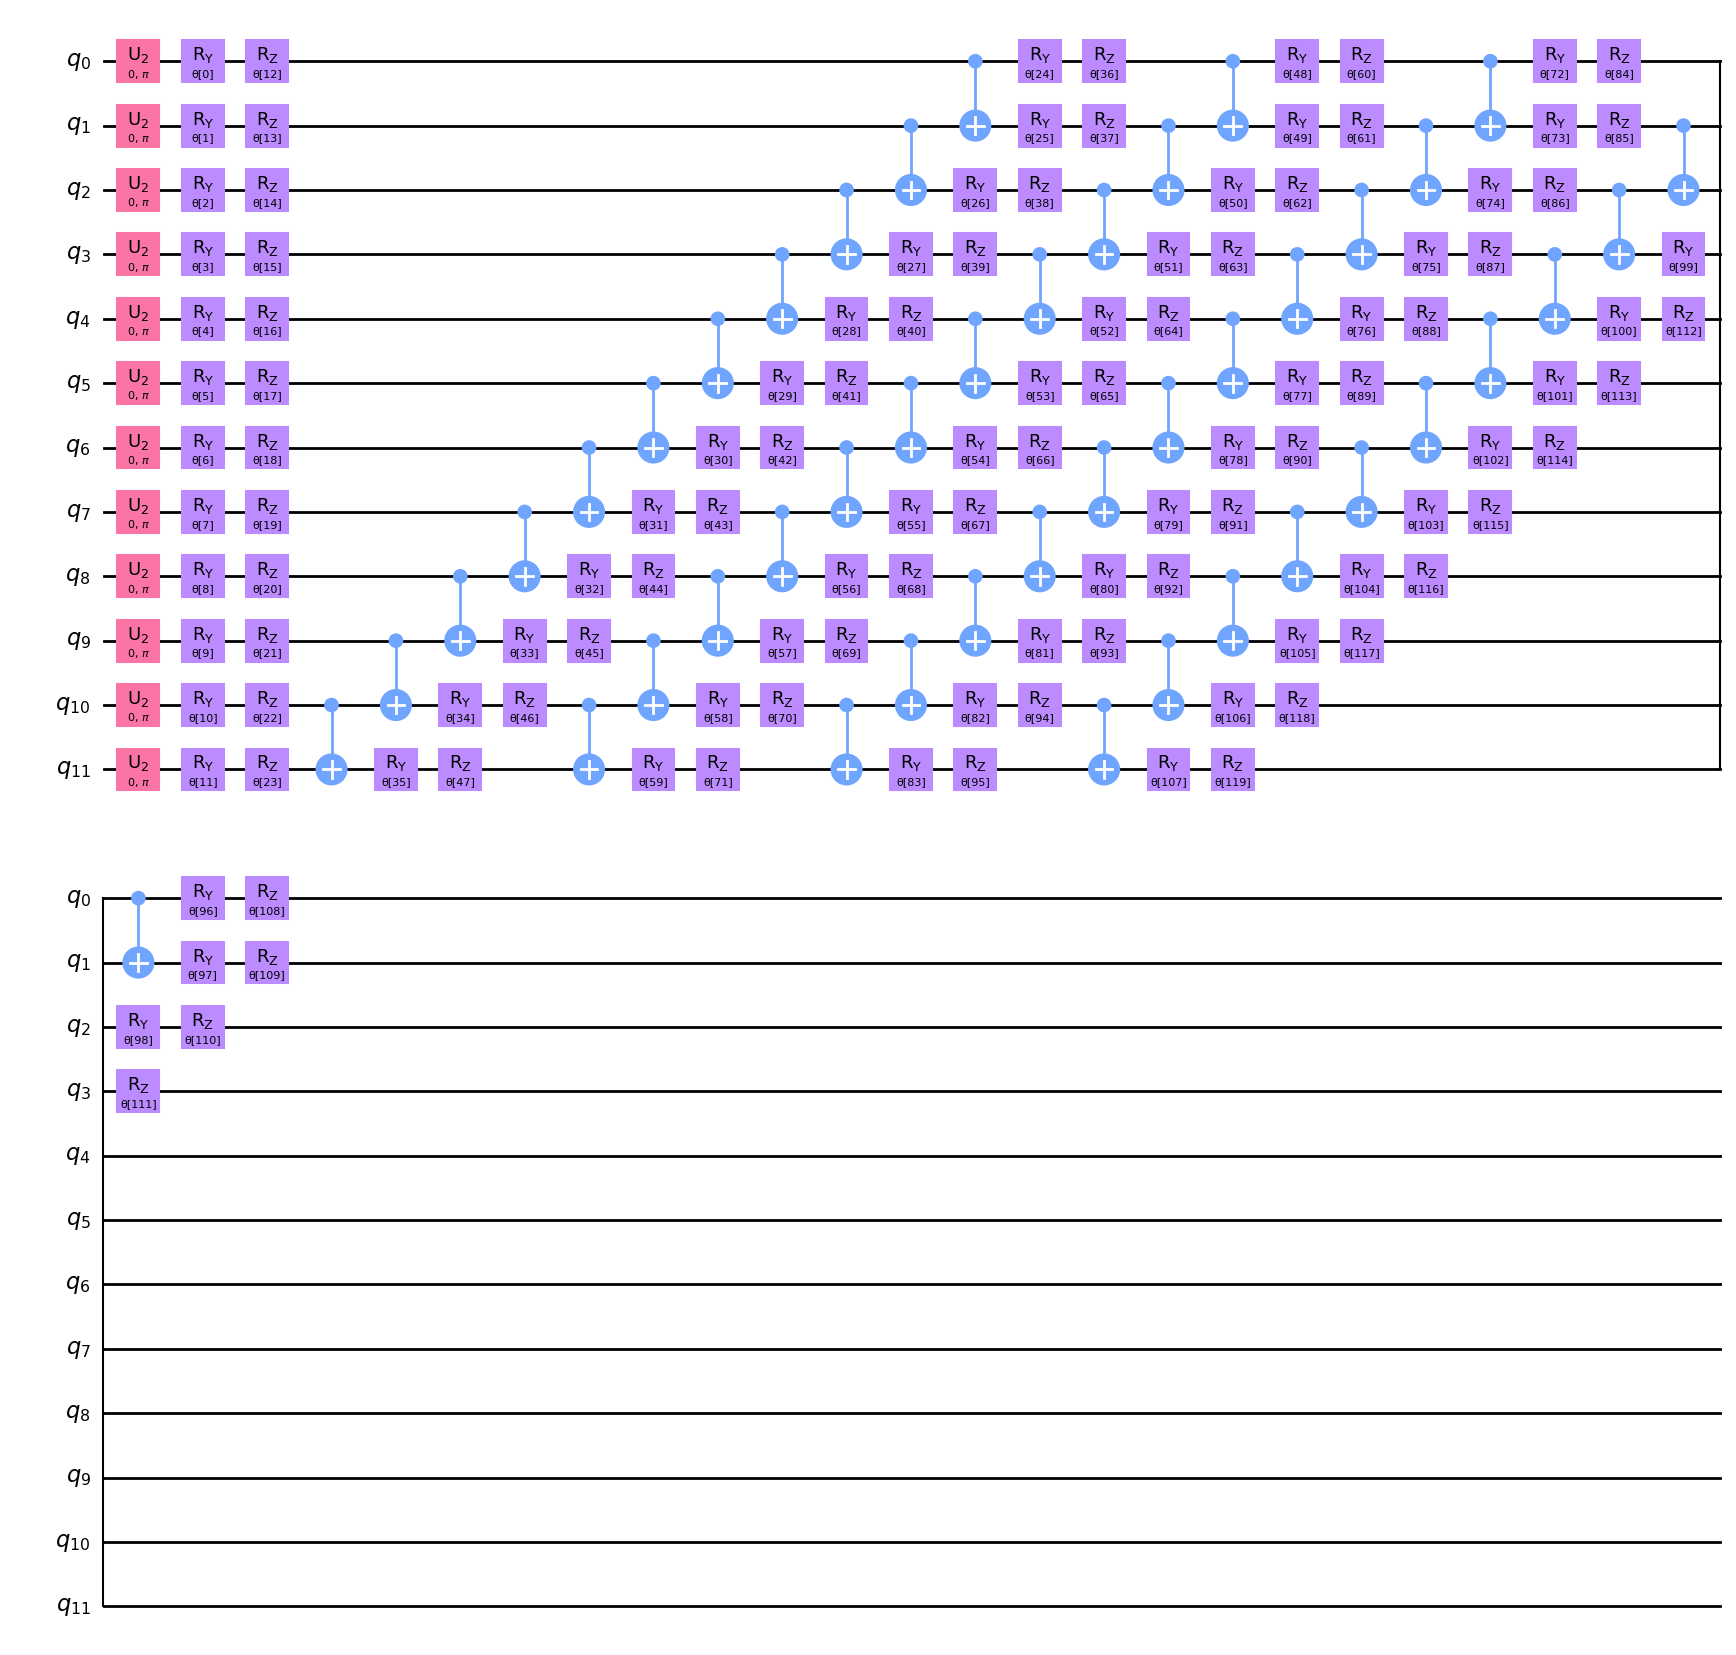

In [42]:
qc.decompose().draw(output="mpl", style="clifford")

In [43]:
qc.num_parameters

120

In [44]:
from qiskit.primitives import Sampler

shots = 5000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

<ipython-input-44-4b5b9f4bb99d>:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})


In [45]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(120)
    print(initial_weights.shape)
    return TorchConnector(qnn, initial_weights)

In [46]:
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
class Discriminator(nn.Module):
    def __init__(self, input_size):

        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 10)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [47]:
generator = create_generator()
discriminator = Discriminator(num_dim)


(120,)


In [48]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    print(w.shape)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [49]:
from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

In [50]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

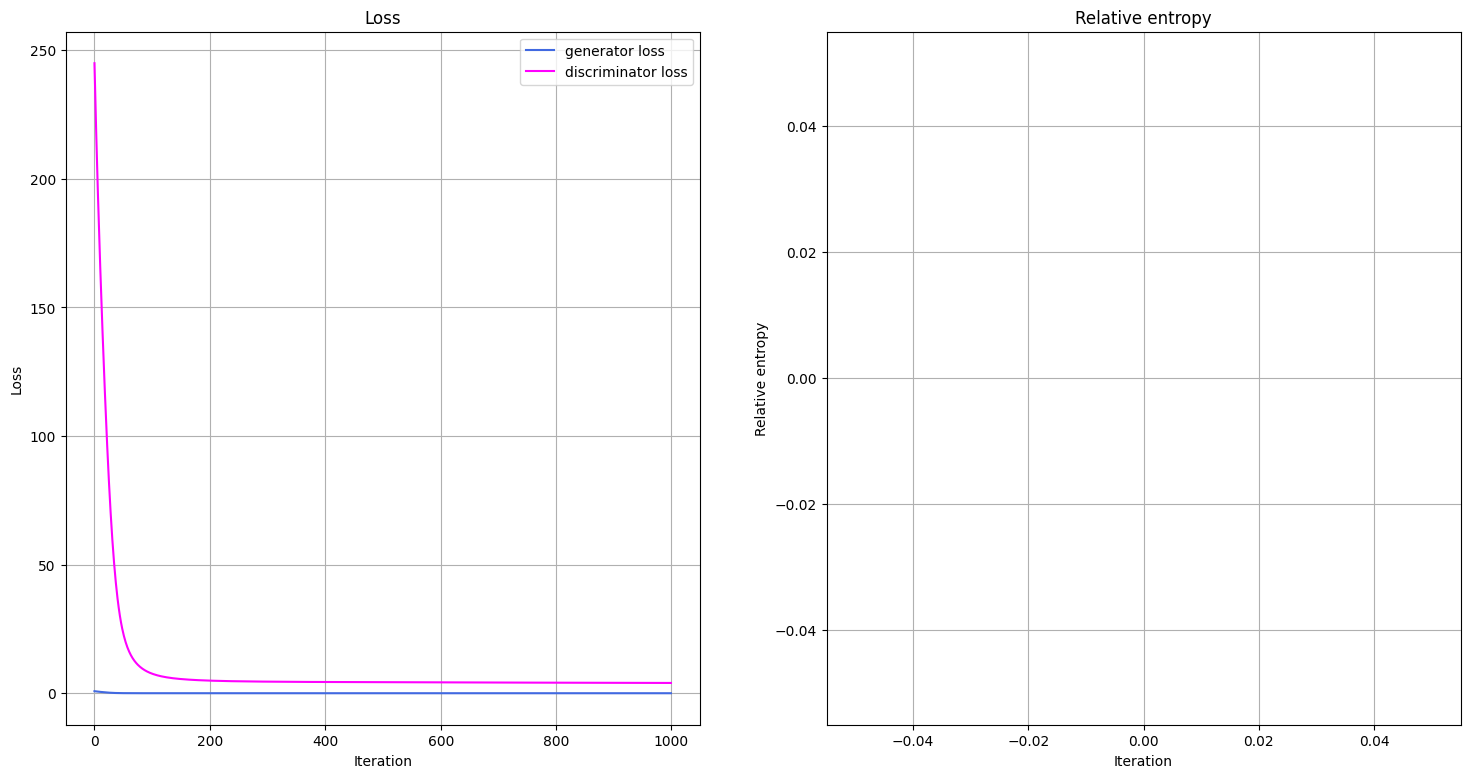

Fit in 24436.53 sec


In [51]:
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 1000

num_qnn_outputs = num_discrete_values**num_dim
device = torch.device("cpu")

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float).to(device)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float).to(device)

    # Configure input
    real_dist = torch.tensor(grid_data, dtype=torch.float).reshape(-1, 1)
    real_dist = real_dist.to(device)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    # samples = samples.reshape(-1,4)
    samples = samples.to(device)
    print(device)
    disc_value = discriminator(samples)
    disc_value = disc_value.to(device)
    print(disc_value.shape)
    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)
    print(gen_dist.shape)
    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), grid_data.reshape(-1,1))
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

In [53]:
# Save model parameters
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'generator_optimizer_state_dict': generator_optimizer.state_dict(),
    'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
    'generator_loss_values': generator_loss_values,
    'discriminator_loss_values': discriminator_loss_values,
    'entropy_values': entropy_values,
}, 'qgan_1vs2.pth')

In [ ]:
# Load model parameters and additional information
checkpoint = torch.load('qgan_1vs2.pth')

# Restore model and optimizer states
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

# Restore additional information
generator_loss_values = checkpoint['generator_loss_values']
discriminator_loss_values = checkpoint['discriminator_loss_values']
entropy_values = checkpoint['entropy_values']
accuracy_values = checkpoint['accuracy_values']